# Этап 1: Градиентный бустинг

In [1]:
import pandas as pd
import numpy as np
import io
import timeit

from sklearn.model_selection import KFold, cross_val_predict
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

PATH = 'C:\\Users\\Dmatryus\\YandexDisk\\Education\\Self\\ML\\Data'

In [2]:
train_data = pd.read_csv(PATH + '\\features.csv')
train_f = train_data[train_data.columns[:-6]]
train_f.head()

match_id  start_time  lobby_type  r1_hero  r1_level  r1_xp  r1_gold  r1_lh  \
0         0  1430198770           7       11         5   2098     1489     20   
1         1  1430220345           0       42         4   1188     1033      9   
2         2  1430227081           7       33         4   1319     1270     22   
3         3  1430263531           1       29         4   1779     1056     14   
4         4  1430282290           7       13         4   1431     1090      8   

   r1_kills  r1_deaths  ...  radiant_ward_sentry_count  \
0         0          0  ...                          0   
1         0          1  ...                          0   
2         0          0  ...                          1   
3         0          0  ...                          0   
4         1          0  ...                          0   

   radiant_first_ward_time  dire_bottle_time  dire_courier_time  \
0                     35.0             103.0              -84.0   
1                    -20.0             149.0              -84.0   
2                    -39.0              45.0              -77.0   
3                    -30.0             124.0              -80.0   
4                     46.0             182.0              -80.0   

   dire_flying_courier_time  dire_tpscroll_count  dire_boots_count  \
0                     221.0                    3                 4   
1                     195.0                    5                 4   
2                     221.0                    3                 4   
3                     184.0                    0                 4   
4                     225.0                    6                 3   

   dire_ward_observer_count  dire_ward_sentry_count  dire_first_ward_time  
0                         2                       2                 -52.0  
1                         3                       1                  -5.0  
2                         3                       1                  13.0  
3                         2                       0                  27.0  
4                         3                       0                 -16.0  

[5 rows x 103 columns]

In [3]:
classes = train_data['radiant_win']

In [4]:
tf_count = dict(train_f.count())
scips = list(filter(lambda a: a[1] < len(train_f), tf_count.items()))
f_scips = []
for i in scips:
    f_scips.append(i[0])
f_scips

['first_blood_time',
 'first_blood_team',
 'first_blood_player1',
 'first_blood_player2',
 'radiant_bottle_time',
 'radiant_courier_time',
 'radiant_flying_courier_time',
 'radiant_first_ward_time',
 'dire_bottle_time',
 'dire_courier_time',
 'dire_flying_courier_time',
 'dire_first_ward_time']

Пропуски в первых 4 признака понятны интуитивно - это события, которые могли не произойти за первые 5 минут игры.

Остальные признаки - приобретаемые в ходе игры признаки команды, основанные на предметах. Команды за первые 5 минут игры, могли не проводить манипуляции с предметами, соответсвующими признакам. 

In [5]:
train_f = train_f.fillna(0)
train_f.head()

match_id  start_time  lobby_type  r1_hero  r1_level  r1_xp  r1_gold  r1_lh  \
0         0  1430198770           7       11         5   2098     1489     20   
1         1  1430220345           0       42         4   1188     1033      9   
2         2  1430227081           7       33         4   1319     1270     22   
3         3  1430263531           1       29         4   1779     1056     14   
4         4  1430282290           7       13         4   1431     1090      8   

   r1_kills  r1_deaths  ...  radiant_ward_sentry_count  \
0         0          0  ...                          0   
1         0          1  ...                          0   
2         0          0  ...                          1   
3         0          0  ...                          0   
4         1          0  ...                          0   

   radiant_first_ward_time  dire_bottle_time  dire_courier_time  \
0                     35.0             103.0              -84.0   
1                    -20.0             149.0              -84.0   
2                    -39.0              45.0              -77.0   
3                    -30.0             124.0              -80.0   
4                     46.0             182.0              -80.0   

   dire_flying_courier_time  dire_tpscroll_count  dire_boots_count  \
0                     221.0                    3                 4   
1                     195.0                    5                 4   
2                     221.0                    3                 4   
3                     184.0                    0                 4   
4                     225.0                    6                 3   

   dire_ward_observer_count  dire_ward_sentry_count  dire_first_ward_time  
0                         2                       2                 -52.0  
1                         3                       1                  -5.0  
2                         3                       1                  13.0  
3                         2                       0                  27.0  
4                         3                       0                 -16.0  

[5 rows x 103 columns]

In [6]:
def clasification_series(features, classes, classifier_name, float_p, show_process=True):
    kf = KFold(5, True)
    tr = []
    r = dict()
    clfrs = dict()
    times = dict()
    for i in float_p:
        a = timeit.default_timer()
        if classifier_name == 'GBC':
            classifier = GradientBoostingClassifier(n_estimators=i, max_depth=5)
            t_features = features.values
        elif classifier_name == 'LR':
            classifier = LogisticRegression(C=i)
            scaler = StandardScaler()
            t_features = scaler.fit_transform(features)
        validation = kf.split(t_features)  
        tr = np.array([])
        for j in validation:
            classifier.fit(t_features[j[0]], classes[j[0]])
            p = classifier.predict_proba(t_features[j[1]])[:, 1]
            tr = np.append(tr, roc_auc_score(classes[j[1]], p))
        r[i] = tr.mean()
        t_time = timeit.default_timer() - a
        if show_process:
            print(i, t_time, r[i])
        clfrs[i] = classifier
        times[i] = t_time
    return r, times, clfrs

def fib_array(stop_n, start_n=1, scale = 1):
    a = 0
    b = 1
    n = stop_n
    r = np.array([], dtype=int)
    for __ in range(n):
        a, b = b, a + b
        if a >= start_n:
            r = np.append(r, a)
    return r * scale

def auc_roc_and_time_plot(auc_roc_time, name='', hp_name='hp', log10 = False):
    ylabels = ('AUC-ROC', 'time')
    for j, p in enumerate(auc_roc_time):
        plt.figure(j+1)
        X = p.keys()
        if log10:
            X = np.log10(list(X))
        Y = p.values()
        plt.plot(X, Y, marker='o', linestyle='--', linewidth=3, markersize=17)
        plt.xlabel(hp_name)
        plt.ylabel(ylabels[j])
        plt.grid()
        plt.title('{} {}'.format(name, ylabels[j]))
        
    plt.show()
    s = sorted(auc_roc_time[0].items(), key=lambda a: a[1], reverse=True)
    best_hp = s[0][0]
    print(' best {} = {}\n'.format(hp_name, best_hp), "AUC-ROC = {}\n".format(s[0][1]), 'time: {}'.format(auc_roc_time[1][s[0][0]]))
    return best_hp


In [7]:
trees = fib_array(9, scale = 10)[1:]
trees

array([ 10,  20,  30,  50,  80, 130, 210, 340])

In [8]:
gr = clasification_series(train_f, classes, 'GBC', trees)

10 63.744801100000004 0.6784583991671039
20 128.1211412 0.691949037328235
30 193.80111389999996 0.6983225029984748
50 322.79752890000003 0.7048883859639735
80 510.7161814 0.7090121814136117
130 825.6440679999998 0.7150512495972287
210 1312.3234822 0.7178333092552599
340 2089.4919308999997 0.7197056114270733


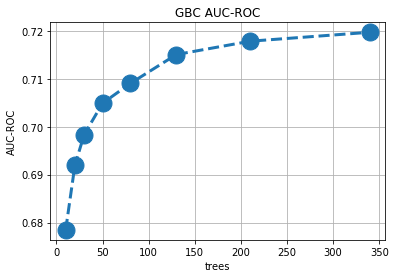

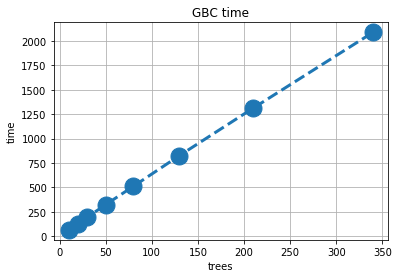

 best trees = 340
 AUC-ROC = 0.7197056114270733
 time: 2089.4919308999997


340

In [9]:
auc_roc_and_time_plot(gr[:-1], 'GBC', 'trees')

## Отчет - подход 1
### 1. Пропуски в данных
Признаки с пропусками:
`first_blood_time`, 
`first_blood_team`,
`first_blood_player1`,
`first_blood_player2`,
`radiant_bottle_time`,
`radiant_courier_time`,
`radiant_flying_courier_time`,
`radiant_first_ward_time`,
`dire_bottle_time`,
`dire_courier_time`,
`dire_flying_courier_time`,
`dire_first_ward_time`
 
Пропуски в первых 4 признака понятны интуитивно - это события, которые могли не произойти за первые 5 минут игры.

Остальные признаки - приобретаемые в ходе игры признаки команды, основанные на предметах. Команды за первые 5 минут игры, могли не проводить манипуляции с предметами, соответсвующими признакам.

### 2. Целевая переменная
`radiant_win` - целевая переменная, обозначающая победу одной из команд

### 3. Время кросс-валидации на 30 деревьев
На 30 деревьях при максимальной их глубине - 5 оценка AUC-ROC получилась 0.6983. за 180 секунд (зависит от аппаратного обеспечения, так на ультрабуке считалось за 240)

### 4. Оценка качества модели на кросс-валидации
После 30 деревьев оценка всё ещё продолжает расти, но все медленнее и медленнее. В данном случае решение о количестве деревьев в модели следует принимать, исходя из вычислительных возможностей и разумного времени работы. В рассмотренном наборе параметров, я бы предпочел останавиться на 130 деревьях. Для ускорения можно уменьшить глубину деревьев, но это может повлиять на качество классификации.

# Этап 2: Логистическая регрессия

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
cp = [cp for cp in [pow(10, i) for i in range(-7, 3)]]
lr = clasification_series(train_f, classes, 'LR', cp)

1e-07 2.573283900000206 0.6872797685298033
1e-06 2.951950300000135 0.6880624777417729
1e-05 3.474714999999378 0.6952066406620057
0.0001 5.207278900000347 0.7113089724963307
0.001 9.508077100000264 0.7162372338856542
0.01 12.954919900000277 0.7164842677125358
0.1 13.29944019999948 0.7166074294289791
1 13.193548600000213 0.7162620569866824
10 13.842275799999697 0.7163763723546297
100 13.357903799999804 0.7163742570162025


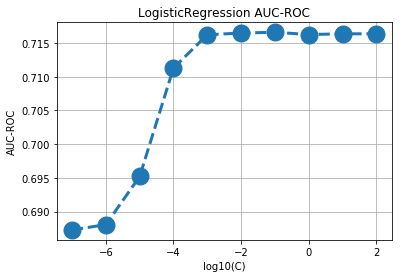

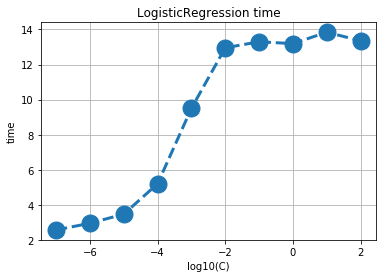

 best log10(C) = 0.1
 AUC-ROC = 0.7166074294289791
 time: 13.29944019999948


0.1

In [12]:
auc_roc_and_time_plot(lr[:-1], 'LogisticRegression', 'log10(C)', log10=True)

In [13]:
def drop_categorial(data):
    hero_i = np.arange(3, 83, 8)
    dp = data.drop(data.columns[hero_i], axis=1)
    return dp.drop('lobby_type', axis=1)

In [14]:
wc_train_f = drop_categorial(train_f)
short_lr = clasification_series(wc_train_f, classes, 'LR', cp)

1e-07 2.1730026000004727 0.6871706263432502
1e-06 2.509212399999342 0.6881505343296495
1e-05 3.048198699999375 0.6951455567472241
0.0001 4.580881700000646 0.7112649721082502
0.001 8.649785200000224 0.7162626249289001
0.01 11.448298799999975 0.7163436456512817
0.1 12.442533799999183 0.7166132980286479
1 12.997196799999983 0.7165034952613484
10 12.293909099999837 0.7163568118675758
100 11.70046900000034 0.716259945347479


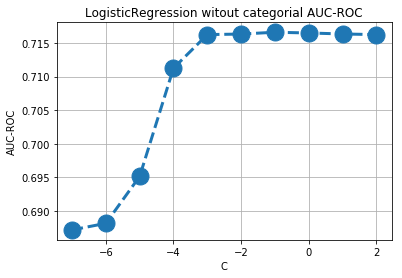

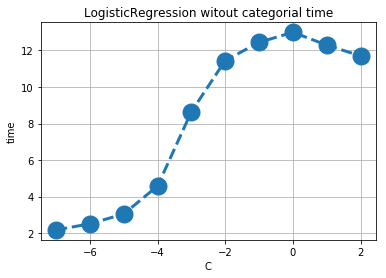

 best C = 0.1
 AUC-ROC = 0.7166132980286479
 time: 12.442533799999183


0.1

In [15]:
auc_roc_and_time_plot(short_lr[:-1], 'LogisticRegression witout categorial', 'C', log10=True)

In [16]:
def get_heroes_num(data):
    hero_i = np.arange(3, 83, 8)
    heroes = set()
    for i in hero_i:
        heroes = heroes.union(data[data.columns[i]].unique())
    return max(heroes)

heroes_num = get_heroes_num(train_f)
heroes_num

112

In [17]:
def heroes_bag(data):
    X_pick = np.zeros((data.shape[0], heroes_num))

    for i, match_id in enumerate(data.index):
        for p in range(5):
            X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
            X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
            
    return X_pick

def hb_df(data):
    heroes_columns = ('{}_hero'.format(n) for n in range(heroes_num))
    hb = heroes_bag(data)
    return pd.DataFrame(hb, columns=heroes_columns)

def hb_transform(data):
    hb = hb_df(data)
    wcd = drop_categorial(data)
    return pd.concat([wcd, hb], axis=1)

In [18]:
hb_train_f = hb_transform(train_f)

In [23]:
long_lr = clasification_series(hb_train_f, classes, 'LR', cp)

1e-07 4.028949499999726 0.7006753889982988
1e-06 4.437585099999524 0.7023391324693893
1e-05 5.38437950000025 0.7149230930370821
0.0001 8.180329799999527 0.7429156325335905
0.001 14.924739999999474 0.7515128521298823
0.01 20.664856800000052 0.7520935749032482
0.1 23.996861499999795 0.7516568635073619
1 22.44426939999994 0.7520584055751964
10 22.735544199999822 0.7517058213589964
100 22.52665590000015 0.7519478875661662


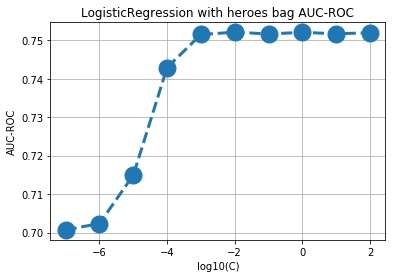

 best log10(C) = 0.01
 AUC-ROC = 0.7520935749032482
 time: 20.664856800000052


In [24]:
best_C = auc_roc_and_time_plot(long_lr[:-1], 'LogisticRegression with heroes bag', 'log10(C)', log10=True)

In [25]:
test = pd.read_csv(PATH + '\\features_test.csv')
test = test.fillna(0)
transform_test = hb_transform(test)
scaler = StandardScaler()
ttt = scaler.fit_transform(transform_test)

In [26]:
lr = long_lr[2][best_C].predict_proba(ttt)[:,1]
lr

array([0.82620618, 0.77014979, 0.21431163, ..., 0.25068494, 0.63731974,
       0.43926171])

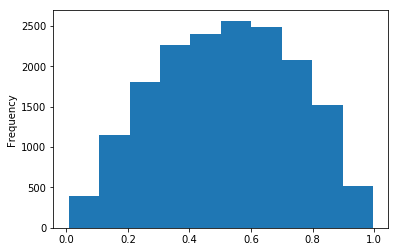

In [29]:
pd.Series(lr).plot.hist(bins=10)

In [32]:
print('min:', lr.min(), '\nmax:', lr.max())

min: 0.007863698297514038 
max: 0.996426031949393


## Отчет - подход 2

### 1. Качество логистической регрессии
Даже если брать предсказание логистической регрессии над всеми признаками, получается, что AUC-ROC оценка у неё лучше, чем бустинга на 50 деревьях:0.704 и 0.7165 соответственно, при том, что обучается логистическая регресиия почти в 30 раз быстрее, хотя разница оценки не большая, разница во времени весьма существенна. 

Думаю, что это связано с тем, что логистическая регресиия даёт оценки с меньшей уверенностью, поэтому меньше штрафуется за ошибки, которые вполне вероятны, учитывая что за время игры может много всего произойти, а состояние на первых 5 минутах игры не определяет всю игру. Кроме того, можно сделать предположение, что пространство хорошо разделяется линейно.

### 2. Влияние удаления категориальных признаков
После удаления категориальных признаков оценка не изменилась, но сократилось время работы алгоритма. По-видимому, они не имели существенного значения в исходном виде, так как разница между героями учитывалась последовательностью их индексации, производилась попытка сопоствать вероятность победы с порядковым номером героев, данный результат можно интерпретировать, как отсутствие зависимости межну нумерацией героев, типом игры и шансом победить.

### 3. Количество индикаторов героев
Если судить по предоставленным данным, индикаторов 112, однако не все из них используются в выборке.

### 4. Влияние "мешка слов"
Добавление "мешка слов" позволило улучшить качество алгоритма до 0.752, что является существенным приростом, при этом скорость работы алгоритма увеличилась вдвое. Прирост можно объяснить тем, что теперь выбор героя действительно значим для алгоритма, так как он оценивает влияние на победу каждого героя в отдельности, а не пытается найти зависимость от нумерации. Интуитивно понятно, что выбор героев - это важный фактор, влиящий на победу, а изменение качества алгоритма подтверждает это.

### 5. Минимально и максимальное значение прогноза
Лучшим алгоритмом оказалась логистическая регрессия построенная с признаками "мешка слов". Получилось так, что коэффициент регулиризации не сильно влияет на качество алгоритма, что означает отсутствие корреляции между признаками.

Минимальное значение прогноза оказалось 0.007, а максимальным 0.996.